## Ecommerce Trade Sales

In [38]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Reading and Filtering data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


### Time series plot of Ecommerce trade sales

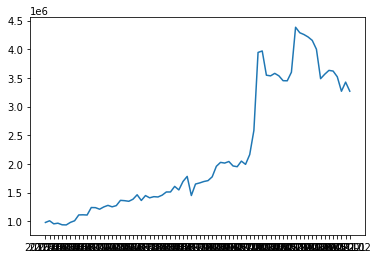

In [5]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [6]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [7]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


**Growth Rate of Ecommerce Retail Sales**

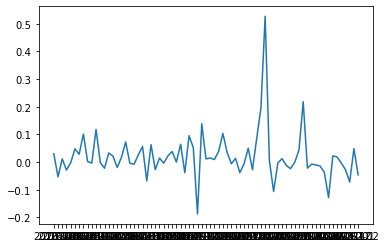

In [8]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [9]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02,1006610,0.030098
2016-03,953186,-0.053073


**Time series for growth rate**

In [34]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

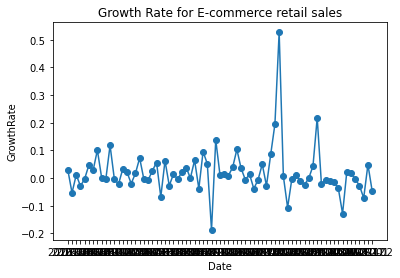

<Figure size 1600x500 with 0 Axes>

In [10]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [132]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [12]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The series is Stationary with 5% level of significant


### Keywords extraction using PyTrend

In [52]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [50]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [51]:
data2.tail()

,Doordash,isPartial
date,,
2022-01-01,100,False
2022-02-01,89,False
2022-03-01,57,False
2022-04-01,84,False
2022-05-01,64,True


### Normalizing time series

In [88]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/ECOMMERCE.csv')

In [15]:
#

In [113]:
for index, row in keywords_csv.iterrows():
    #print(([row['Keyword']]))
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

In [114]:
FinalData

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,57,0,...,0,0,53,38,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,45,48,0,0,0,0,0
2004-03-01,0,0,0,0,0,0,0,0,29,0,...,0,0,42,22,59,0,100,0,0,92
2004-04-01,0,0,0,0,0,0,0,0,11,0,...,0,0,44,47,24,0,0,0,0,49
2004-05-01,0,0,0,0,0,0,0,0,61,0,...,0,0,48,39,21,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,81,100,87,57,44,0,14,0,29,28,...,0,22,53,70,30,81,46,88,56,71
2022-02-01,83,89,24,83,35,0,28,0,21,17,...,37,37,51,70,34,75,14,79,55,52
2022-03-01,77,57,65,87,100,0,16,35,22,6,...,0,33,49,69,29,81,25,88,60,93


In [97]:
FinalData

,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,Canadian Tire,Home Depot,Best Buy,Shopify,Apple,Gap,Old Navy,Joe Fresh,Uber
date,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,57,0,0,0,0,0,0,0,0,0,0
2004-02-01,0,0,0,0,0,0,0,12,0,0,0,0,0,0,100,0,0,0
2004-03-01,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0
2004-04-01,0,0,0,0,0,0,0,11,0,0,0,0,0,19,0,0,0,0
2004-05-01,0,0,0,0,0,0,0,61,0,0,0,0,0,0,87,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,100,87,57,44,0,14,0,29,28,28,9,23,49,77,10,17,0,81
2022-02-01,89,24,83,35,0,28,0,21,17,25,49,31,48,92,0,0,0,83
2022-03-01,57,65,87,100,0,16,35,22,6,22,43,32,47,94,10,69,44,77


In [115]:
FinalData.to_csv('EcommerceKeywordTimeSeries.csv')

**Dictionary of keywords**

In [20]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [21]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [22]:
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Western Union',
  'Bank',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

### Evaluating Category Time Series

In [23]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

C:\Users\hp\AppData\Local\Temp\ipykernel_15100\3972822904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_ts['Growth_rate'][0] = '0'


In [24]:
category_ts.head(2)

,,Growth_rate
date,,
2004-01-01,90,0.000000
2004-02-01,93,0.033333


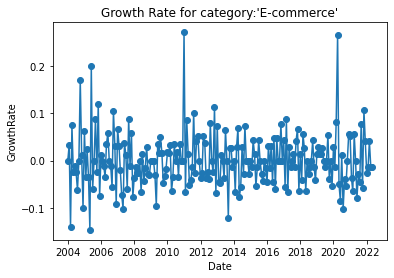

<Figure size 1600x500 with 0 Axes>

In [25]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)


# Display
plt.show()

**Category Stationarity Test**

In [26]:
kpss_test(category_ts['Growth_rate'])

Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [27]:
adf_test(category_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant


### Keywords Time Series from CSV

In [119]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['date'])
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

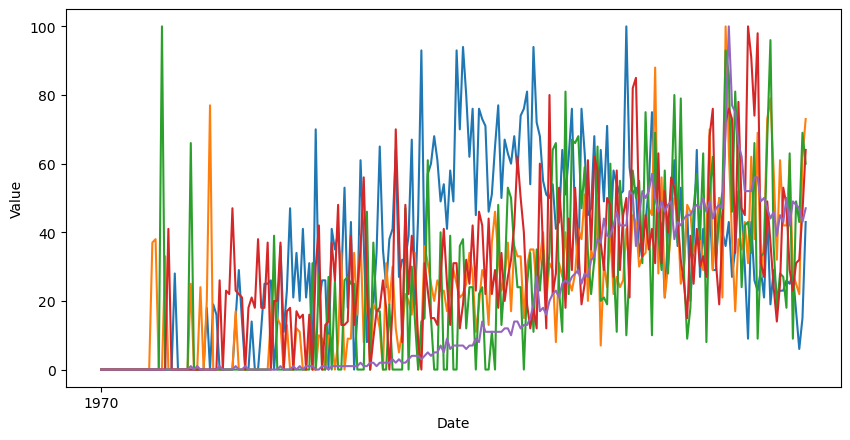

In [135]:
keywordsts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[10:15]], width = 10)

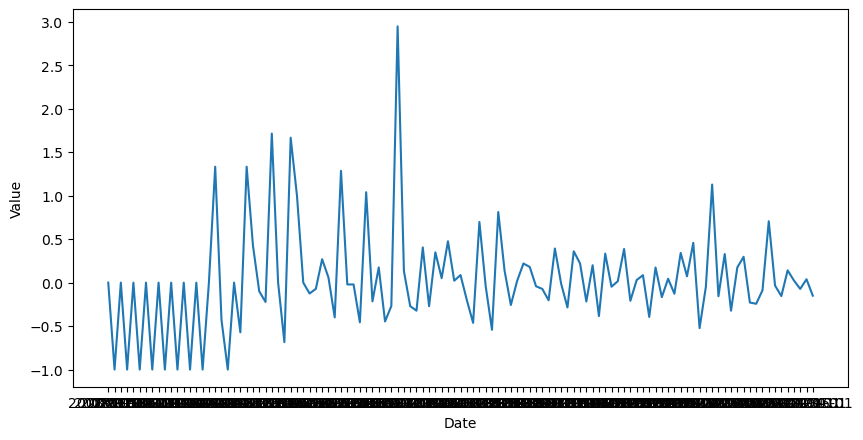

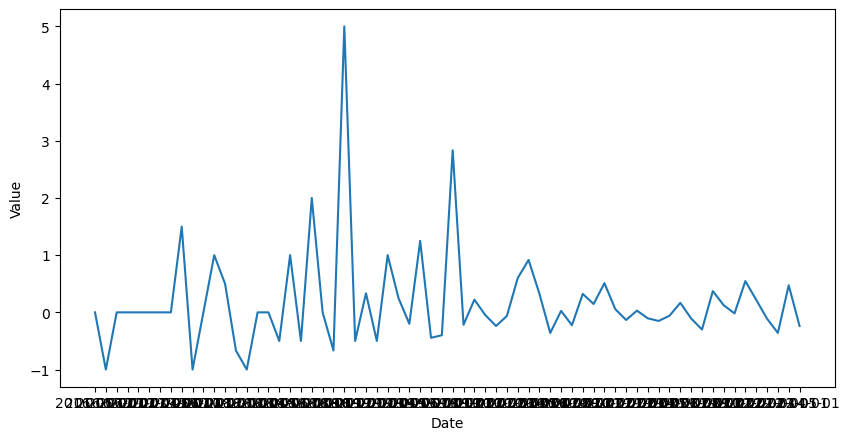

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


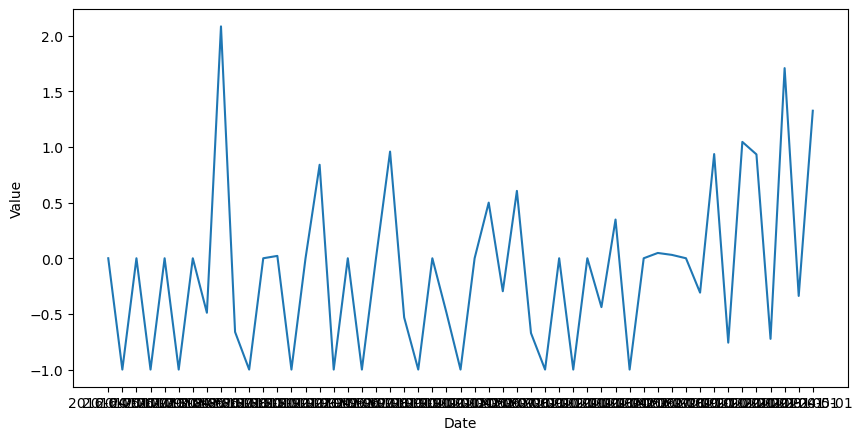

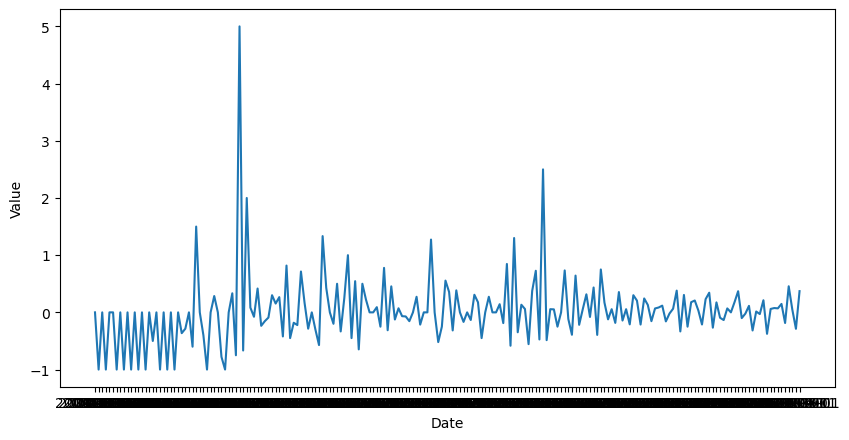

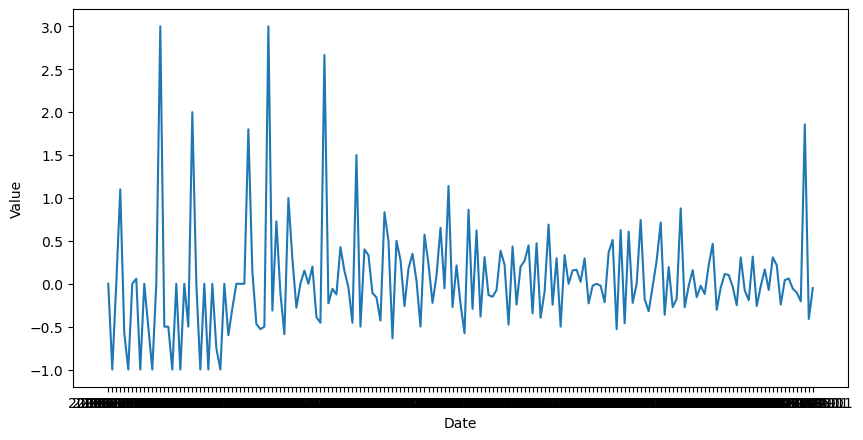

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


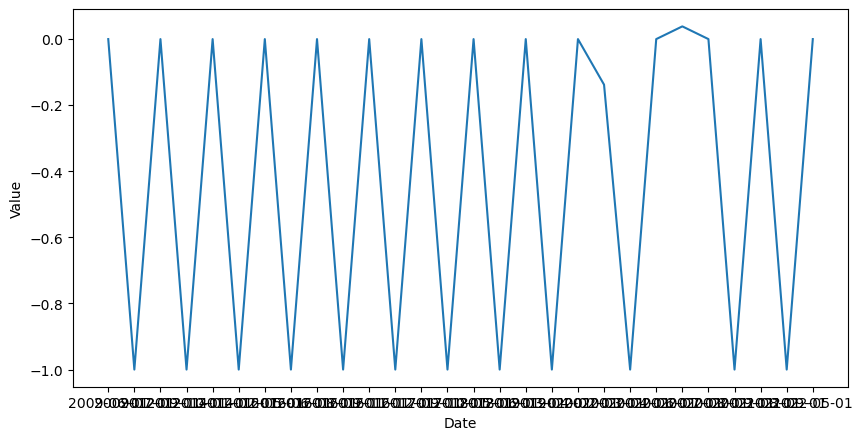

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


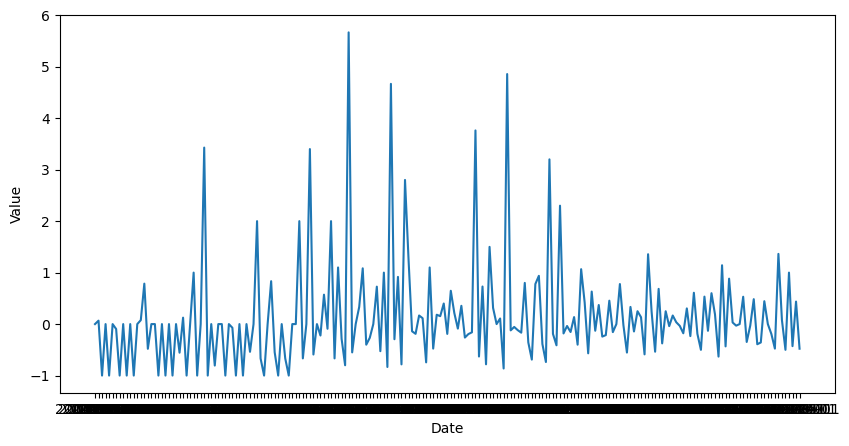

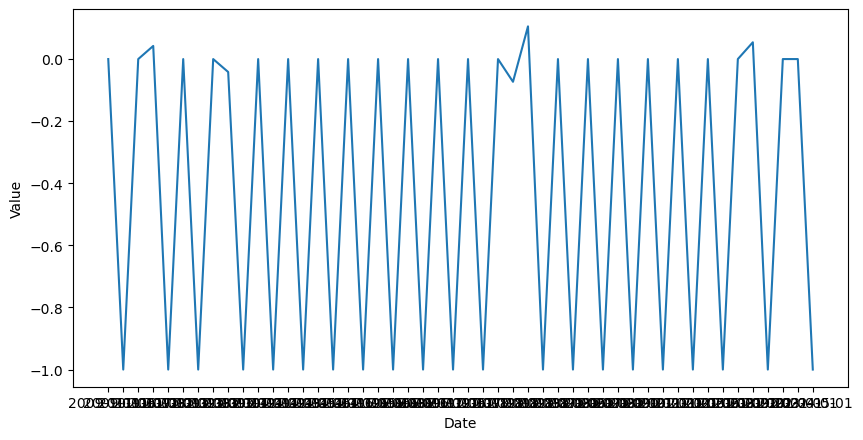

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KeyboardInterrupt: 

In [168]:
for column in ecommerce_keyword_ts:
    df = pd.DataFrame()
    df['Growth_rate'] = ecommerce_keyword_ts[column].pct_change()
    df = df.dropna()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    plot_df(df,width=10)
    adf_test(df['Growth_rate'])
    kpss_test(df['Growth_rate'])


,Uber Growth_rate,DoorDash Growth_rate,SkipTheDishes Growth_rate,Walmart Growth_rate,Costco Growth_rate,Real Canadian Superstore Growth_rate,alibaba Growth_rate,newegg canada Growth_rate,ebay Growth_rate,kijiji Growth_rate,...,Sportchek Growth_rate,square online Growth_rate,PayPal Growth_rate,Western Union Growth_rate,TD Canada Trust Growth_rate,Scotiabank Growth_rate,Royal Bank of Canada Growth_rate,Google Pay Growth_rate,Apple Pay Growth_rate,Mastercard Growth_rate
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.044444,-0.360656,-0.296296,0.174603,-0.043478,inf,-0.631579,inf,0.210526,-0.372093,...,inf,-0.03,-0.127907,-0.043956,0.153846,-0.051948,0.157895,-0.028571,0.125,-0.128571


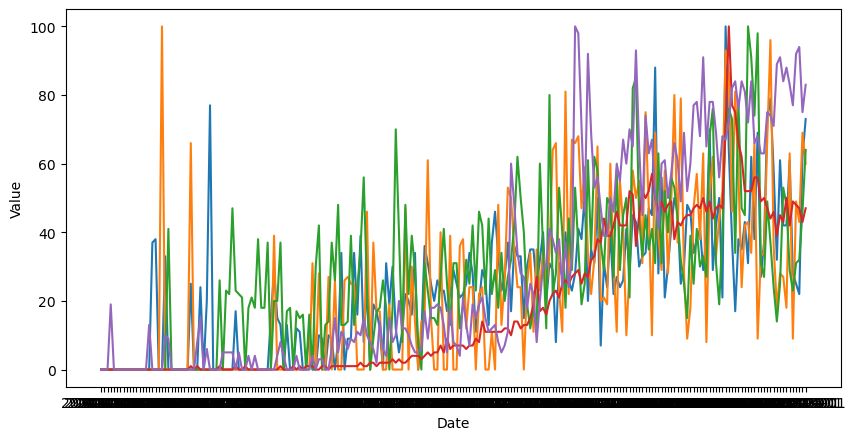

In [128]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

In [30]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

def cat_dict():
    
    # get time series and related queries and topics of categories
    for i, category in enumerate(cat_lst):
        category = str(category)
        data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
        cat_queries_dict[category] = queries
        cat_topics_dict[category] = topics

        #Code to append data for different columns in data frame
        if i == 0:
            data.rename(columns = {'': category}, inplace = True)
            categoryts = data.drop(columns=['isPartial'])
        else:
            data.rename(columns = {'': category}, inplace = True)
            data = data.drop(columns=['isPartial'])
            categoryts = categoryts.join(data)

# Remove the trend

### Function to extract the trend and remove it

In [127]:
def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


In [124]:
ecommerce_keyword_ts.head()

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,57,0,...,0,0,53,38,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,45,48,0,0,0,0,0
2004-03-01,0,0,0,0,0,0,0,0,29,0,...,0,0,42,22,59,0,100,0,0,92
2004-04-01,0,0,0,0,0,0,0,0,11,0,...,0,0,44,47,24,0,0,0,0,49
2004-05-01,0,0,0,0,0,0,0,0,61,0,...,0,0,48,39,21,0,0,0,0,0


In [126]:
ecommerce_keyword_ts.isnull().values.any()

False

In [133]:
#transformed_data = remove_downward_trend_bias(ecommerce_keyword_ts, ecommerce_keyword_ts)

In [42]:
ecommerce_keyword_ts.head()

,Uber,DoorDash,SkipTheDishes,Just Eat,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,90,90,90,90,90,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
2004-02-01,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
2004-03-01,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
2004-04-01,86,86,86,86,86,86,86,86,86,86,...,86,86,86,86,86,86,86,86,86,86
2004-05-01,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84


# Normalize data

In [130]:
def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# difference
def detrend(dataframe):
    return dataframe.diff().dropna()


# seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# cyclicity 
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [131]:
#temp = remove_downward_trend_bias(retailsales1, retailsales1, freq = 'M')
temp1 = normalize(ecommerce_keyword_ts)
temp2 = detrend(detrend(temp1))
#temp3 = remove_seasonality(temp2)
check_stationarity(temp2)

Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is not stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significa

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
R

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
R

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
Result from the ADF Stationarity Test: 
The series is Stationary with 5% level of significant
Result from the KPSS Stationarity Test: 
The series is stationary with 5% level of significant
All other series are stationary


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
